In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import requests

In [13]:
# Data Collection and Preparation
def fetch_bitcoin_data():
    url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart'
    params = {'vs_currency': 'usd', 'days': '365', 'interval': 'daily'}
    response = requests.get(url, params=params)
    data = response.json()
    print(data)
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['Date', 'Close_Price'])
    df['Date'] = pd.to_datetime(df['Date'], unit='ms')
    df.set_index('Date', inplace=True)
    df['Close_Price'].fillna(method='ffill', inplace=True)
    return df

In [14]:
data = fetch_bitcoin_data()

{'prices': [[1690848000000, 29233.136365580438], [1690934400000, 29537.109746927432], [1691020800000, 29146.63627084363], [1691107200000, 29176.15059658541], [1691193600000, 29087.938086007627], [1691280000000, 29046.800457023197], [1691366400000, 29044.204375577556], [1691452800000, 29178.147751873083], [1691539200000, 29779.56167125089], [1691625600000, 29585.48807737921], [1691712000000, 29423.81891597763], [1691798400000, 29396.8479714205], [1691884800000, 29412.142274584105], [1691971200000, 29284.96971374381], [1692057600000, 29400.58680419105], [1692144000000, 29170.490397060614], [1692230400000, 28754.197021112574], [1692316800000, 26501.58726991974], [1692403200000, 26042.838256848998], [1692489600000, 26104.778630797897], [1692576000000, 26160.700419818215], [1692662400000, 26119.005958595222], [1692748800000, 26033.675406585844], [1692835200000, 26450.00862461353], [1692921600000, 26134.934254516003], [1693008000000, 26044.036209289134], [1693094400000, 26002.015717319366], 

/tmp/ipykernel_213509/2681192822.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Close_Price'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_213509/2681192822.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close_Price'].fillna(method='ffill', inplace=True)


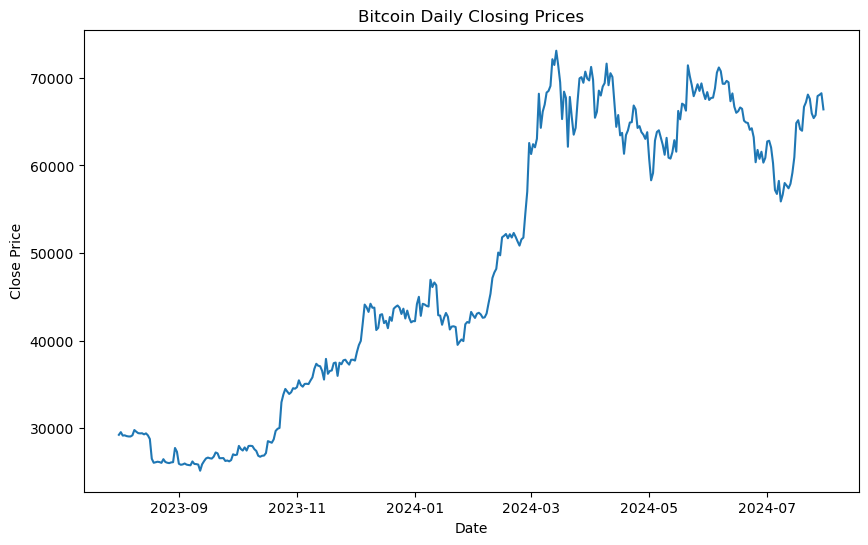

In [15]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
plt.plot(data['Close_Price'])
plt.title('Bitcoin Daily Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [16]:
# Rolling mean and standard deviation
rolling_mean = data['Close_Price'].rolling(window=30).mean()
rolling_std = data['Close_Price'].rolling(window=30).std()

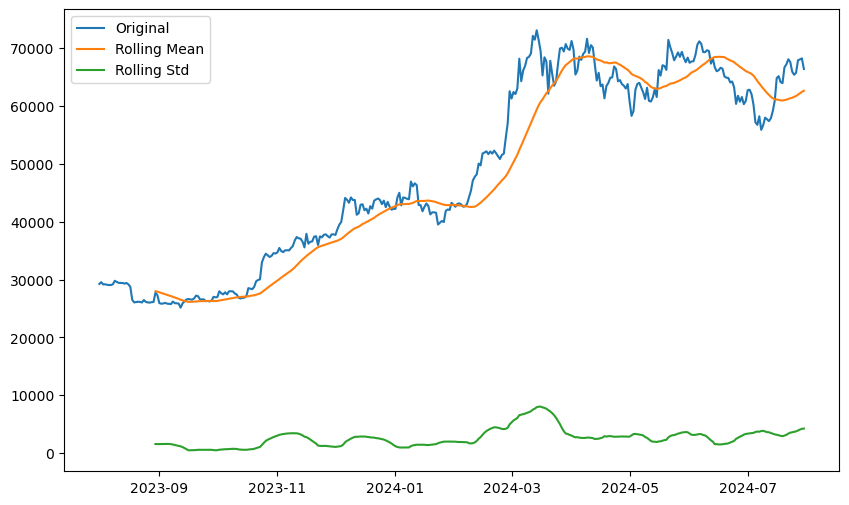

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close_Price'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.show()

In [19]:
# Autocorrelation and partial autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

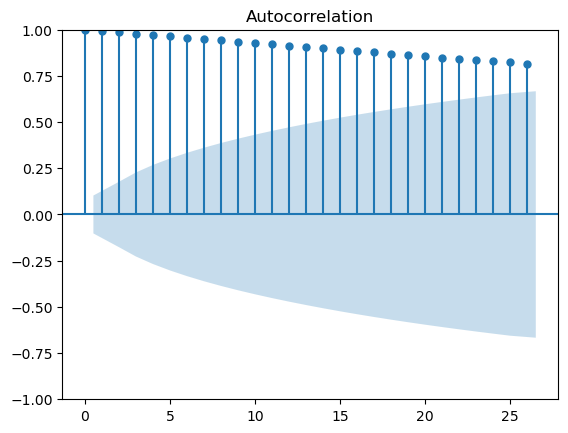

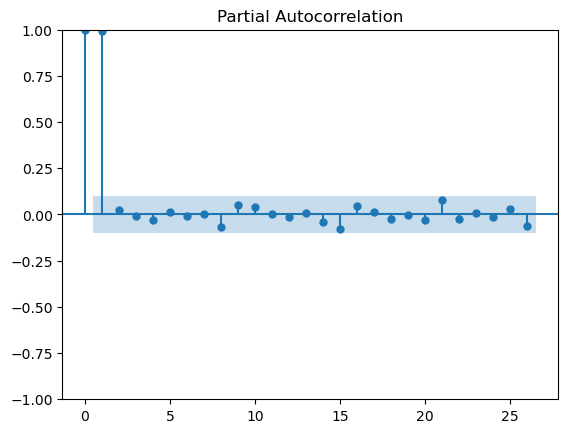

In [20]:
plot_acf(data['Close_Price'])
plot_pacf(data['Close_Price'])
plt.show()

In [21]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

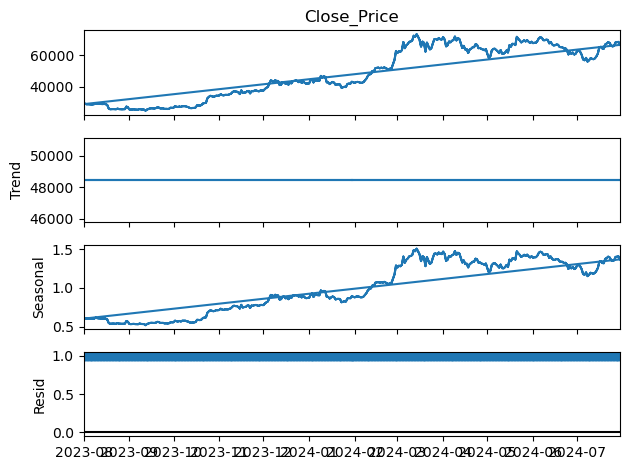

In [24]:
doubled_data = pd.concat([data['Close_Price'], data['Close_Price']])
decomposition = seasonal_decompose(doubled_data, model='multiplicative', period=365)
decomposition.plot()
plt.show()

In [25]:
# Augmented Dickey-Fuller test
result = adfuller(data['Close_Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.7818497194065691
p-value: 0.8243955248331396


In [26]:
# Model Selection and Parameter Tuning
model = auto_arima(data['Close_Price'], start_p=0, start_q=0,
                   test='adf', max_p=5, max_q=5, m=1,
                   d=None, seasonal=False, start_P=0,
                   D=0, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6290.116, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6289.970, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6289.955, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6290.161, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6291.955, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6291.980, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6293.864, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6290.418, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.522 seconds


In [27]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3141.978
Date:                Wed, 31 Jul 2024   AIC                           6289.955
Time:                        00:11:42   BIC                           6301.647
Sample:                             0   HQIC                          6294.602
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    115.1701     67.548      1.705      0.088     -17.221     247.561
ma.L1         -0.0636      0.031     -2.019      0.043      -0.125      -0.002
sigma2      1.852e+06   8.39e+04     22.090      0.0

In [28]:
# Model Training
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [29]:
model = ARIMA(train_data['Close_Price'], order=model.order)
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                  292
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2511.769
Date:                Wed, 31 Jul 2024   AIC                           5027.538
Time:                        00:11:48   BIC                           5034.884
Sample:                    08-01-2023   HQIC                          5030.481
                         - 05-18-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0680      0.031     -2.164      0.030      -0.130      -0.006
sigma2       1.85e+06   8.96e+04     20.640      0.000    1.67e+06    2.03e+06
Ljung-Box (L1) (Q):                   1.38   Jarque-

/root/miniconda3/envs/ds/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/miniconda3/envs/ds/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/miniconda3/envs/ds/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [30]:
# Forecasting
forecast = results.forecast(steps=len(test_data))
forecast_index = test_data.index

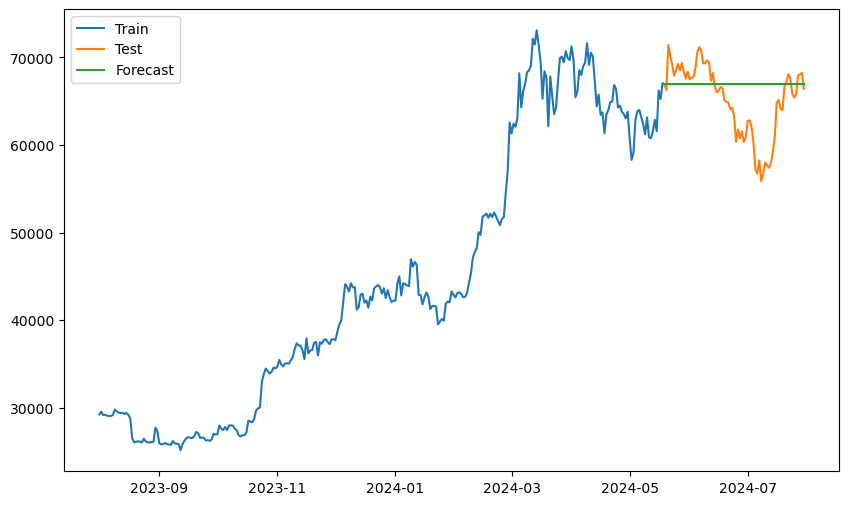

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['Close_Price'], label='Train')
plt.plot(test_data['Close_Price'], label='Test')
plt.plot(forecast_index, forecast, label='Forecast')
plt.legend()
plt.show()

In [32]:
# Model Validation and Refinement
mse = mean_squared_error(test_data['Close_Price'], forecast)
mae = mean_absolute_error(test_data['Close_Price'], forecast)
rmse = np.sqrt(mse)

In [33]:
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

MSE: 20162875.514428947, MAE: 3348.9492248855568, RMSE: 4490.3090666933995


In [43]:
rolling_forecast_index = pd.date_range(start=data.index[-1], periods=8)


In [41]:
rolling_forecast = results.get_forecast(steps=7)

ValueError: x and y must have same first dimension, but have shapes (8,) and (7,)

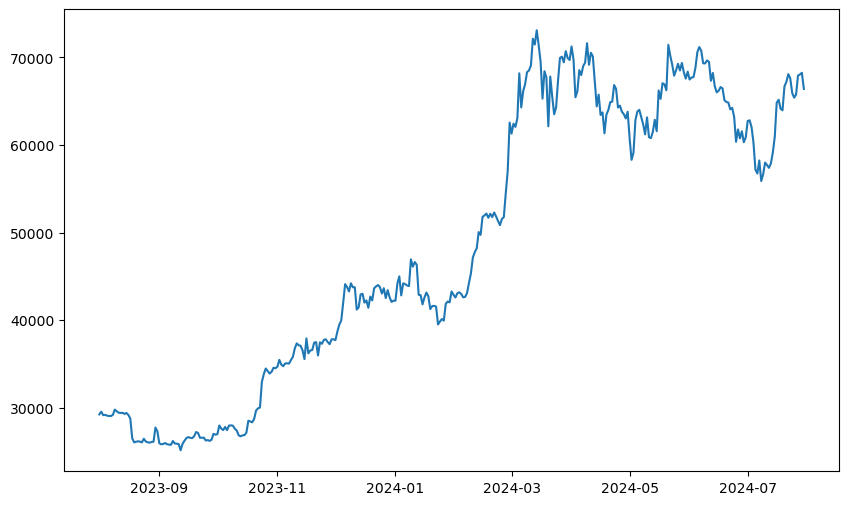

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close_Price'], label='Historical')
plt.plot(rolling_forecast_index, rolling_forecast.predicted_mean, label='Rolling Forecast')
plt.legend()
plt.show()

KeyError: 'Close_Pprice'